In [113]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
%matplotlib inline

In [2]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)

### Replace nuclide concentrations with ratios

- cs137/cs133
- cs134/cs137
- cs135/cs137
- ba136/ba138
- sm150/sm149
- sm152/sm149
- eu154/eu153
- pu240/pu239
- pu241/pu239
- pu242/pu239

In [3]:
ratios = XY.loc[:, lbls].copy()

In [4]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)

In [5]:
### filter trainXY ###
trainXY = ratios.loc[ratios['Burnup'] > 0].copy()
trainXY = trainXY.sample(frac=0.5)
#trainXY.shape
trainXY.sample(15)

(36573, 15)

In [10]:
# Choosing PHWR sample intentionally
sim_idx = 65332
test_exist = trainXY.loc[trainXY.index == sim_idx]
test_exist

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239


In [11]:
test_sample = ratios.loc[ratios.index == sim_idx].drop(lbls, axis=1)
test_answer = ratios.loc[ratios.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
65332,phwr,1885.822793,0.711,3383.22,candu37


In [12]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [14]:
unc = 0.07
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
X = trainXY.drop(lbls, axis=1)
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)

In [15]:
# split into groups for plotting
trainXY_pwr = trainXY.loc[trainXY['ReactorType'] == 'pwr'].copy()
trainXY_agr = trainXY.loc[trainXY['ReactorType'] == 'agr'].copy()
trainXY_phwr = trainXY.loc[trainXY['ReactorType'] == 'phwr'].copy()

In [16]:
medall = trainXY['LogLikelihood'].median()
medpwr = trainXY_pwr['LogLikelihood'].median()
medagr = trainXY_agr['LogLikelihood'].median()
medphwr = trainXY_phwr['LogLikelihood'].median()
statall = stats.describe(trainXY['LogLikelihood'])
statpwr = stats.describe(trainXY_pwr['LogLikelihood'])
statagr = stats.describe(trainXY_agr['LogLikelihood'])
statphwr = stats.describe(trainXY_phwr['LogLikelihood'])
print(f'All Median: {medall} Stats: {statall} \n')
print(f'PWR Median: {medpwr} Stats: {statpwr} \n')
print(f'AGR Median: {medagr} Stats: {statagr} \n')
print(f'PHWR Median: {medphwr} Stats: {statphwr} \n')

All Median: -356.5016288951512 Stats: DescribeResult(nobs=36573, minmax=(-114407670.01787183, 48.28783953694015), mean=-818863.610372254, variance=53348580041306.47, skewness=-9.71973885272645, kurtosis=97.97142938649871) 

PWR Median: -335.8795230907285 Stats: DescribeResult(nobs=16917, minmax=(-1014139.4935359645, -124.94324060711799), mean=-4183.325345244941, variance=812756111.7066585, skewness=-20.694780370581615, kurtosis=526.283175077629) 

AGR Median: -382.6309944477167 Stats: DescribeResult(nobs=8567, minmax=(-312129.2739188493, -100.16585796504086), mean=-2630.587776894984, variance=158580577.78228724, skewness=-12.615320091591581, kurtosis=204.21823154990204) 

PHWR Median: -375.83414350667715 Stats: DescribeResult(nobs=11089, minmax=(-114407670.01787183, 48.28783953694015), mean=-2692307.0846599583, variance=170922940943290.88, skewness=-5.158161177090783, kurtosis=26.36595830975397) 



In [120]:
meds = [medall, medagr, medpwr, medphwr]
min(meds), statall.minmax[1]

(-382.6309944477167, 48.28783953694015)

In [17]:
plotXY1 = trainXY_pwr.loc[trainXY_pwr['LogLikelihood'] > medpwr]
plotXY2 = trainXY_agr.loc[trainXY_agr['LogLikelihood'] > medagr]
plotXY3 = trainXY_phwr.loc[trainXY_phwr['LogLikelihood'] > medphwr]
plotXY4 = trainXY.loc[trainXY['LogLikelihood'] > medall]

In [18]:
rxtrs = ['PWR', 'AGR', 'PHWR', 'All']
plots = [plotXY1, plotXY2, plotXY3, plotXY4]

In [124]:
def plotme(plots, pltlabels, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY['LogLikelihood']
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Log Likelihood', fontsize=14, labelpad=15)
        ax.set_xlim(0, 10000)
        ax.set_zlim(vmin, 50)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

## LogLikelihood for 3 reactors with Uncertainty = 7%

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


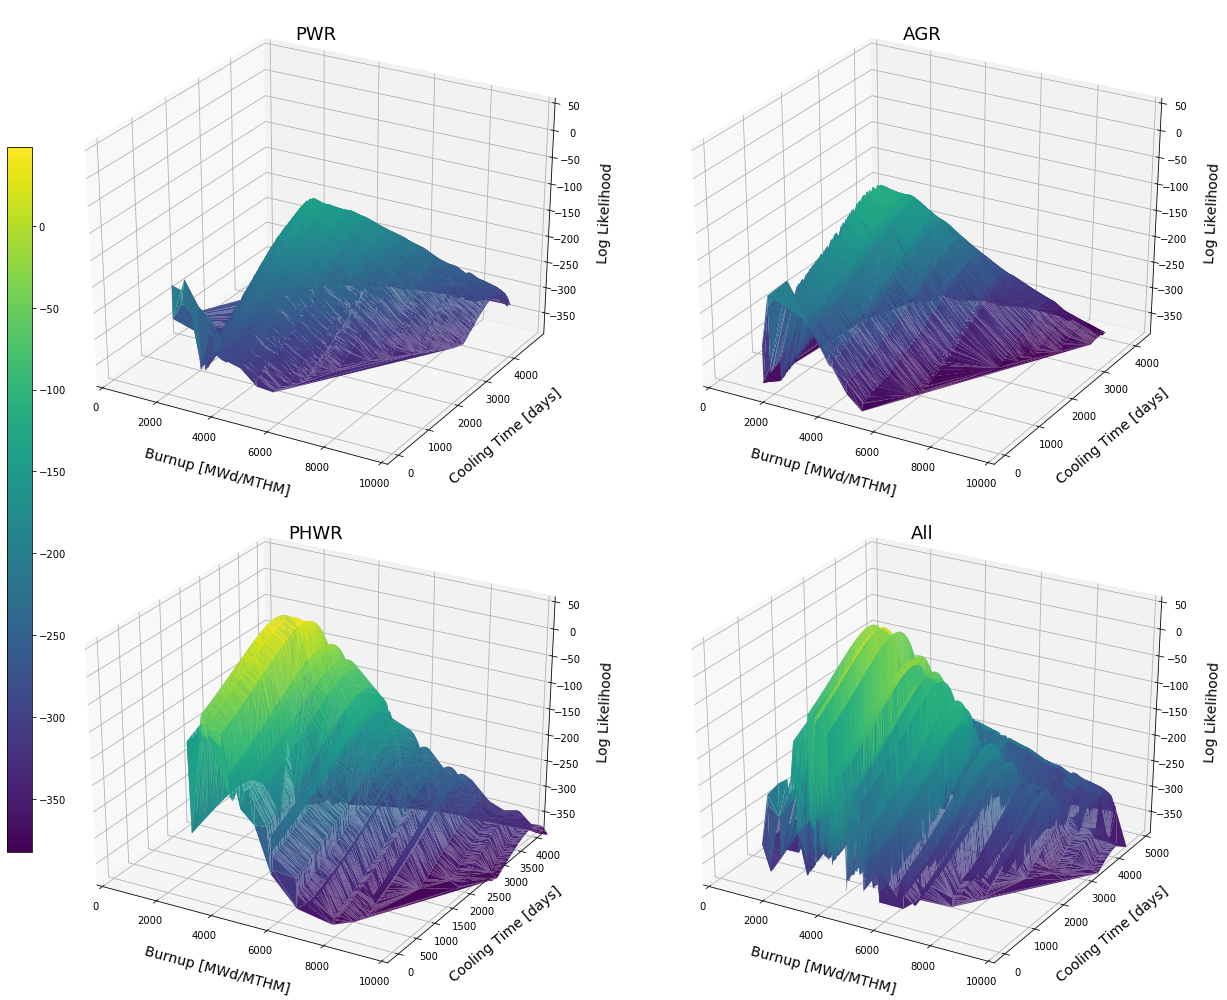

In [125]:
plotme(plots, rxtrs, vmin=min(meds), vmax=statall.minmax[1])

In [119]:
uncs = [0.07, 0.14, 0.28]
for unc in uncs:
    ll_name = 'LogLikelihood_' + str(unc)
    trainXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
#    unc_name = 'LLUncertainty_' + str(unc)
#    trainXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

In [121]:
trainXY.sample(10)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239,LogLikelihood,LogLikelihood_0.07,LogLikelihood_0.14,LogLikelihood_0.28
44137,agr,417.662251,3.630,2602.55,agr,0.900191,0.005700,0.501772,0.002372,11.133455,5.059415,0.036997,0.083548,0.010400,0.000316,-202.321010,-202.321010,-24.673517,14.539753
8837,pwr,2989.457592,3.690,946.26,ce14x14,0.765554,0.000190,0.329339,0.001299,2.284052,1.096509,0.009318,0.022156,0.000897,0.000011,-20545.451851,-20545.451851,-5098.315442,-1241.729943
45726,agr,1222.572508,3.630,4009.51,agr,0.856786,0.004325,0.530029,0.003151,17.544803,8.474910,0.042392,0.124783,0.021105,0.001133,-251.889245,-251.889245,-39.695672,8.154118
23544,pwr,5945.062478,2.990,6762.83,vver1000,0.648213,0.000147,0.374612,0.003829,19.002217,9.800443,0.023020,0.135198,0.021265,0.002975,-3942.095843,-3942.095843,-959.887193,-219.533634
14829,pwr,2800.137613,3.690,7309.57,ce14x14,0.793168,0.002519,0.319941,0.004220,20.968456,10.498063,0.051214,0.139659,0.039992,0.003970,-285.430415,-285.430415,-49.398580,4.410775
9528,pwr,65.057679,3.690,1854.07,ce14x14,0.924103,0.005788,0.268045,0.001743,4.826757,2.260789,0.032978,0.041862,0.004676,0.000077,-1296.063378,-1296.063378,-293.946604,-48.616014
27001,pwr,4385.133133,3.740,1829.59,vver1000,0.703548,0.000143,0.355082,0.001806,4.688685,2.202446,0.012506,0.041311,0.002553,0.000074,-5404.948129,-5404.948129,-1317.158329,-300.409483
55261,phwr,1399.359472,0.711,4077.27,candu19,0.846715,0.001791,0.327682,0.001677,17.353207,9.602529,0.033845,0.067663,0.003883,0.000155,11.412349,11.412349,30.939506,30.622691
52954,phwr,3286.506520,0.711,1946.04,candu19,0.751565,0.000155,0.378518,0.001217,8.080903,3.984948,0.011568,0.030850,0.000655,0.000015,-10472.247981,-10472.247981,-2582.199803,-614.886362
16526,pwr,6018.875961,3.690,8696.70,ce14x14,0.650574,0.000190,0.393005,0.004771,23.593429,11.719713,0.027973,0.158019,0.034730,0.006439,-2281.864060,-2281.864060,-546.731715,-118.147233


In [126]:
med7 = trainXY['LogLikelihood_0.07'].median()
med14 = trainXY['LogLikelihood_0.14'].median()
med28 = trainXY['LogLikelihood_0.28'].median()
stat7 = stats.describe(trainXY['LogLikelihood_0.07'])
stat14 = stats.describe(trainXY['LogLikelihood_0.14'])
stat28 = stats.describe(trainXY['LogLikelihood_0.28'])
print(f'7% Median: {med7} Stats: {stat7} \n')
print(f'14% Median: {med14} Stats: {stat14} \n')
print(f'28% Median: {med28} Stats: {stat28} \n')

7% Median: -356.5016288951512 Stats: DescribeResult(nobs=36573, minmax=(-114407670.01787183, 48.28783953694015), mean=-818863.610372254, variance=53348580041306.47, skewness=-9.71973885272645, kurtosis=97.97142938649871) 

14% Median: -67.29204330892142 Stats: DescribeResult(nobs=36573, minmax=(-28601866.44898937, 41.375443491151785), mean=-204689.50811574716, variance=3334277660114.513, skewness=-9.719741888260621, kurtosis=97.97149334057941) 

28% Median: -0.2015694964917749 Stats: DescribeResult(nobs=36573, minmax=(-7150420.755372612, 34.49286399876764), mean=-51151.18115547471, variance=208390205683.9593, skewness=-9.719754027923651, kurtosis=97.97174912405116) 



In [17]:
plotXY1 = trainXY.loc[trainXY['LogLikelihood'] > med7]
plotXY2 = trainXY.loc[trainXY['LogLikelihood'] > med14]
plotXY3 = trainXY.loc[trainXY['LogLikelihood'] > med28]

In [18]:
rxtrs = ['7% Unc', '14% Unc', '28% Unc']
plots = [plotXY1, plotXY2, plotXY3]

## LogLikelihood for 3 (estimated simulated) Uncertainty values: 7%, 14%, 28%
This is std/scale in logpdf function

In [ ]:
plotme(plots, rxtrs, vmin=min(meds), vmax=statall.minmax[1])

In [15]:
# split into groups for plotting
trainXY_pwr = trainXY.loc[trainXY['ReactorType'] == 'pwr'].copy()
trainXY_agr = trainXY.loc[trainXY['ReactorType'] == 'agr'].copy()
trainXY_phwr = trainXY.loc[trainXY['ReactorType'] == 'phwr'].copy()

In [16]:
medall = trainXY['LogLikelihood'].median()
medpwr = trainXY_pwr['LogLikelihood'].median()
medagr = trainXY_agr['LogLikelihood'].median()
medphwr = trainXY_phwr['LogLikelihood'].median()
statall = stats.describe(trainXY['LogLikelihood'])
statpwr = stats.describe(trainXY_pwr['LogLikelihood'])
statagr = stats.describe(trainXY_agr['LogLikelihood'])
statphwr = stats.describe(trainXY_phwr['LogLikelihood'])

print(f'PHWR Median: {medphwr} Stats: {statphwr} \n')

All Median: -356.5016288951512 Stats: DescribeResult(nobs=36573, minmax=(-114407670.01787183, 48.28783953694015), mean=-818863.610372254, variance=53348580041306.47, skewness=-9.71973885272645, kurtosis=97.97142938649871) 

PWR Median: -335.8795230907285 Stats: DescribeResult(nobs=16917, minmax=(-1014139.4935359645, -124.94324060711799), mean=-4183.325345244941, variance=812756111.7066585, skewness=-20.694780370581615, kurtosis=526.283175077629) 

AGR Median: -382.6309944477167 Stats: DescribeResult(nobs=8567, minmax=(-312129.2739188493, -100.16585796504086), mean=-2630.587776894984, variance=158580577.78228724, skewness=-12.615320091591581, kurtosis=204.21823154990204) 

PHWR Median: -375.83414350667715 Stats: DescribeResult(nobs=11089, minmax=(-114407670.01787183, 48.28783953694015), mean=-2692307.0846599583, variance=170922940943290.88, skewness=-5.158161177090783, kurtosis=26.36595830975397) 



In [ ]:
meds = [medall, medagr, medpwr, medphwr]
min(meds), statall.minmax[1]